# Build GPT from scratch

Source: https://youtu.be/kCc8FmEb1nY?si=U0tMEucoV0EaqMMz

## READ THE DATA

In [1]:
with open("data/NEWHOPE.TXT", "r", encoding="utf8") as f:
    text = f.read()

In [2]:
print(f"Length of the dataset in characters: {len(text)}")

Length of the dataset in characters: 199958


In [3]:
print(text[:1000])

A long time ago, in a galaxy far, far, away...

A vast sea of stars serves as the backdrop for the main title. War drums
echo through the heavens as a rollup slowly crawls into infinity.

It is a period of civil war. Rebel spaceships, striking from a hidden base,
have won their first victory against the evil Galactic Empire.
During the battle, Rebel spies managed to steal secret plans to the
Empire's ultimate weapon, the Death Star, an armored space station with
enough power to destroy an entire planet.
Pursued by the Empire's sinister agents, Princess Leia races home aboard
her starship, custodian of the stolen plans that can save her people and
restore freedom to the galaxy...

The awesome yellow planet of Tatooine emerges from a total eclipse, her two
moons glowing against the darkness. A tiny silver spacecraft, a Rebel
Blockade Runner firing lasers from the back of the ship, races through
space. It is pursed by a giant Imperial Stardestroyer. Hundreds of deadly
laserbolts streak fr

In [4]:
# All the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)


 !"&'(),-./012346789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
76


# Tokenizer

Character level tokenizer

In [5]:
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}


def encode(s):
    # Encoder: take a string, output a list of integers
    return [stoi[c] for c in s]


def decode(l):
    # Decoder: take a list of integers, output a string
    return "".join([itos[i] for i in l])


print(encode("hi there!"))
print(decode(encode("hi there!")))

[57, 58, 1, 69, 57, 54, 67, 54, 2]
hi there!


# Build dataset

In [6]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([199958]) torch.int64
tensor([24,  1, 61, 64, 63, 56,  1, 69, 58, 62, 54,  1, 50, 56, 64,  8,  1, 58,
        63,  1, 50,  1, 56, 50, 61, 50, 73, 74,  1, 55, 50, 67,  8,  1, 55, 50,
        67,  8,  1, 50, 72, 50, 74, 10, 10, 10,  0,  0, 24,  1, 71, 50, 68, 69,
         1, 68, 54, 50,  1, 64, 55,  1, 68, 69, 50, 67, 68,  1, 68, 54, 67, 71,
        54, 68,  1, 50, 68,  1, 69, 57, 54,  1, 51, 50, 52, 60, 53, 67, 64, 65,
         1, 55, 64, 67,  1, 69, 57, 54,  1, 62, 50, 58, 63,  1, 69, 58, 69, 61,
        54, 10,  1, 46, 50, 67,  1, 53, 67, 70, 62, 68,  0, 54, 52, 57, 64,  1,
        69, 57, 67, 64, 70, 56, 57,  1, 69, 57, 54,  1, 57, 54, 50, 71, 54, 63,
        68,  1, 50, 68,  1, 50,  1, 67, 64, 61, 61, 70, 65,  1, 68, 61, 64, 72,
        61, 74,  1, 52, 67, 50, 72, 61, 68,  1, 58, 63, 69, 64,  1, 58, 63, 55,
        58, 63, 58, 69, 74, 10,  0,  0, 32, 69,  1, 58, 68,  1, 50,  1, 65, 54,
        67, 58, 64, 53,  1, 64, 55,  1, 52, 58, 71, 58, 61,  1, 72, 50, 67, 10,
       

In [7]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f"Training data lengh: {len(train_data)}")
print(f"Val data length: {len(val_data)}")

Training data lengh: 179962
Val data length: 19996


In [8]:
block_size = 8  # Context lengh
train_data[: block_size + 1]

tensor([24,  1, 61, 64, 63, 56,  1, 69, 58])

In [9]:
x = train_data[:block_size]  # The input is a sequence of lengh block size
y = train_data[1 : block_size + 1]  # The output are the characters + 1
for t in range(block_size):
    context = x[: t + 1]
    target = y[t]
    print(f"When input is {context} the target is: {target}")

When input is tensor([24]) the target is: 1
When input is tensor([24,  1]) the target is: 61
When input is tensor([24,  1, 61]) the target is: 64
When input is tensor([24,  1, 61, 64]) the target is: 63
When input is tensor([24,  1, 61, 64, 63]) the target is: 56
When input is tensor([24,  1, 61, 64, 63, 56]) the target is: 1
When input is tensor([24,  1, 61, 64, 63, 56,  1]) the target is: 69
When input is tensor([24,  1, 61, 64, 63, 56,  1, 69]) the target is: 58


In [10]:
torch.manual_seed(33)
batch_size = 4  # how many independent sequence will be process in parallel?
block_size = 8  # what is the maximun context length for predictions?


def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    return x, y


xb, yb = get_batch("train")
print("inputs:")
print(xb.shape)
print(xb)
print("targets:")
print(yb.shape)
print(yb)

inputs:
torch.Size([4, 8])
tensor([[ 1, 51, 64, 72, 61, 68,  1, 64],
        [67, 62, 69, 67, 64, 64, 65, 54],
        [52, 54, 61, 61, 68,  1, 50, 63],
        [ 1, 69, 64, 72, 50, 67, 53,  1]])
targets:
torch.Size([4, 8])
tensor([[51, 64, 72, 61, 68,  1, 64, 55],
        [62, 69, 67, 64, 64, 65, 54, 67],
        [54, 61, 61, 68,  1, 50, 63, 53],
        [69, 64, 72, 50, 67, 53,  1, 50]])


# Bigram language model

In this baseline, each token only sees itself to predict the next one. It doesn't have a view of the sequence. 

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(33)


class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # Each token directly reads off the logits for the net token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # IDX SIZE: (Batch Size, Sequence_length)
        # Target size: (Batch Size, Sequence length)

        logits = self.token_embedding_table(
            idx
        )  # Logits size: (Batch Size, Sequence Length, C (Vocab_size))

        if targets is None:
            loss = None
        else:
            # Pytorch expets B x C x T
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens: int):
        # idx is (B, Current Sequence Length) array of indices in the current context
        for _ in range(max_new_tokens):
            # Get the predictions
            logits, loss = self(idx)
            # Focus only on the last time step
            logits = logits[:, -1, :]  # Becomes (Batch Size, Vocab Size)
            # Apply softmax to tget probabilities
            probs = F.softmax(logits, dim=-1)  # (Batch Size, Vocab Size)
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (Batch Size , 1)
            # Apprend samples index tot he running sequence
            idx = torch.cat(
                (idx, idx_next), dim=1
            )  # (Batch Size, Curent Sequence_length +1)

        return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)  # Expected loss (-ln(1/vocab_size(76))) = 4.33

torch.Size([32, 76])
tensor(4.8017, grad_fn=<NllLossBackward0>)


In [12]:
idx = torch.zeros((1, 1), dtype=torch.long)
idx = m.generate(idx, max_new_tokens=32)[0].tolist()
print(decode(idx))


tONFxr!tnGyNLOqo28"wh0D4CeIGNjpT


### Train the model

Using device: cuda


Training. Current Loss: nan:   0%|          | 0/10000 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation loss. Step 0: 4.7099


Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation loss. Step 1000: 3.8483


Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation loss. Step 2000: 3.3097


Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation loss. Step 3000: 3.0102


Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation loss. Step 4000: 2.8865


Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation loss. Step 5000: 2.8164


Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation loss. Step 6000: 2.7727


Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation loss. Step 7000: 2.7442


Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation loss. Step 8000: 2.7417


Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation loss. Step 9000: 2.7371


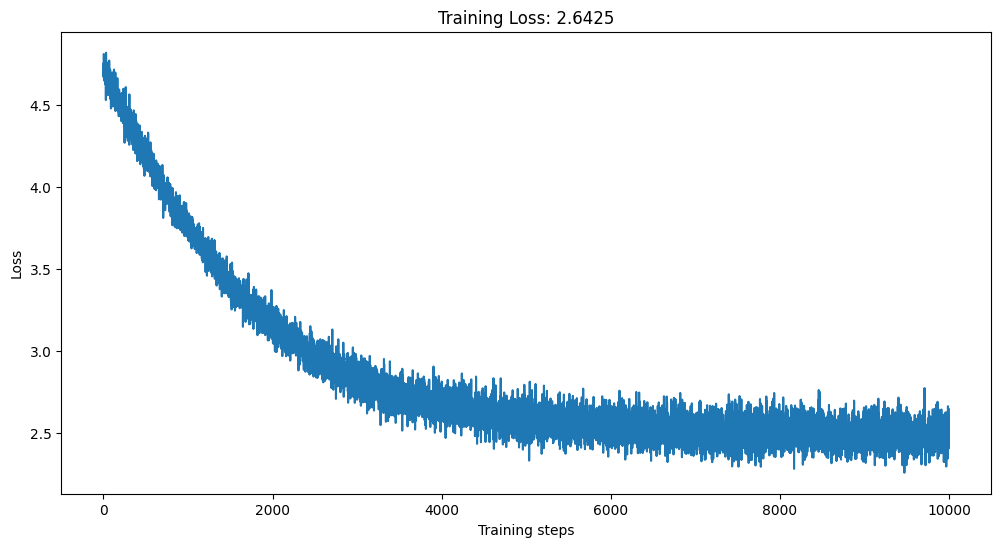

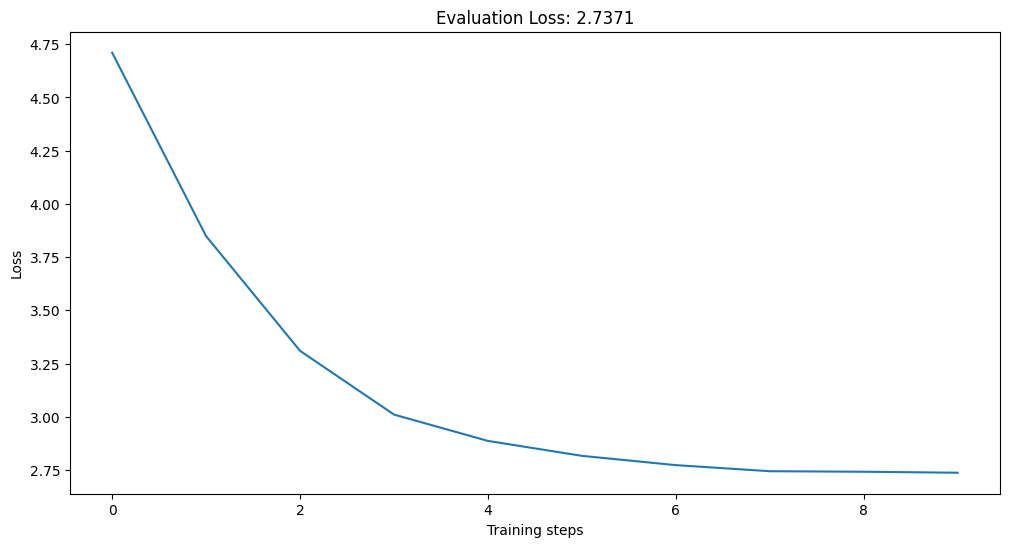

In [15]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

batch_size = 32
num_iterations = 10000
eval_iters = 100

# Use Cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
m = m.to(device)

# Create PyTroch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)


train_losses = []
eval_losses = []


@torch.no_grad()
def eval_model():
    out = []
    m.eval()
    with tqdm(total=eval_iters, desc="Evaluation", leave=False) as pbar:
        for _ in range(eval_iters):
            X, Y = get_batch("val")
            logits, loss = m(X.to(device), Y.to(device))
            out.append(loss.item())
            pbar.update(1)

    m.train()
    return sum(out) / len(out)


with tqdm(total=num_iterations, desc="Training. Current Loss: nan") as pbar:
    for step in range(num_iterations):
        # Sample a batch of data

        xb, yb = get_batch("train")

        # Evaluate the loss
        logits, loss = m(xb.to(device), yb.to(device))

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # print(loss.item())
        train_losses.append(loss.item())
        pbar.set_description(f"Training. Current Loss: {loss.item():.4f}")
        pbar.update(1)

        if step % 1000 == 0:
            avg_loss = eval_model()
            eval_losses.append(avg_loss)
            print(f"Evaluation loss. Step {step}: {avg_loss:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(range(len(train_losses)), train_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title(f"Training Loss: {train_losses[-1]:.4f}")
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(range(len(eval_losses)), eval_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title(f"Evaluation Loss: {eval_losses[-1]:.4f}")
plt.show()

In [16]:
idx = torch.zeros((1, 1), dtype=torch.long).to(device)
idx = m.generate(idx, max_new_tokens=64)[0].tolist()
print(decode(idx))



ONThe CEXTen then d t Des THakes TAG The saplouirt tcthed we he


# The mathematical trick in self-attention

In [18]:
# Consider the following toy example:

torch.manual_seed(33)
B, T, C = 4, 8, 2  # batch, time, channels

x = torch.rand(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [21]:
# Easiest from of comunication. Average the previous tokens until the current one

xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, : t + 1]  # (t,C)
        xbow[b, t] = torch.mean(xprev, 0)

tensor([[0.6186, 0.5587],
        [0.4062, 0.4474],
        [0.3377, 0.5306],
        [0.4125, 0.4342],
        [0.4942, 0.3947],
        [0.4736, 0.4817],
        [0.4107, 0.5155],
        [0.3634, 0.4801]])

In [22]:
x[0]

tensor([[0.6186, 0.5587],
        [0.1937, 0.3360],
        [0.2008, 0.6970],
        [0.6367, 0.1452],
        [0.8213, 0.2365],
        [0.3702, 0.9168],
        [0.0333, 0.7183],
        [0.0325, 0.2320]])

In [23]:
xbow[0]

tensor([[0.6186, 0.5587],
        [0.4062, 0.4474],
        [0.3377, 0.5306],
        [0.4125, 0.4342],
        [0.4942, 0.3947],
        [0.4736, 0.4817],
        [0.4107, 0.5155],
        [0.3634, 0.4801]])

## Make it faster with matrix multiplication

In [25]:
torch.tril(torch.ones(3, 3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [29]:
torch.manual_seed(42)

a = torch.tril(torch.ones(3, 3))
b = torch.randint(0, 10, (3, 2)).float()

print(f"A shape: {a.shape}")
print(f"B shape: {b.shape}")

c = a @ b

print("a=")
print(a)
print("___")
print("b=")
print(b)
print("___")
print("c=")
print(c)

print()
print("We are doing sums (because a is 1s) of the rows of B, but only the first t rows")
print()
print("To do average we need to divide by the number of rows we are summing")
print()
a = torch.tril(torch.ones(3, 3))
a = a / a.sum(1, keepdim=True)

print(f"A shape: {a.shape}")
print(f"B shape: {b.shape}")

c = a @ b

print("a=")
print(a)
print("___")
print("b=")
print(b)
print("___")
print("c=")
print(c)

A shape: torch.Size([3, 3])
B shape: torch.Size([3, 2])
a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
___
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
___
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])

We are doing sums (because a is 1s) of the rows of B, but only the first t rows

To do average we need to divide by the number of rows we are summing

A shape: torch.Size([3, 3])
B shape: torch.Size([3, 2])
a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
___
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
___
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


### Optimize the previous code

In [32]:
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)

xbow2 = (
    wei @ x
)  # Wei (T, T) @ (B, T, C) = (B, T, C) Pytorch will broadcast the first dimension ---> (B, T, C)
print(f"Xboxw shape: {xbow2.shape}")
torch.allclose(xbow, xbow2)

Xboxw shape: torch.Size([4, 8, 2])


True

In [33]:
# Version 3: use Softmax
tril = torch.tril(torch.ones(T, T)) # Tril is all zeros except for the lower triangle
wei = torch.zeros((T, T)) # wei is all zeros
wei = wei.masked_fill(tril == 0, float("-inf")) # Set the upper triangle to -inf

wei = F.softmax(wei, dim=1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

In [34]:
tril   # Tril is all zeros except for the lower triangle

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [36]:
wei  # wei is all zeros

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [37]:
tril = torch.tril(torch.ones(T, T))  # Tril is all zeros except for the lower triangle
wei = torch.zeros((T, T))  # wei is all zeros
wei.masked_fill(tril == 0, float("-inf"))

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [38]:
tril = torch.tril(torch.ones(T, T))  # Tril is all zeros except for the lower triangle
wei = torch.zeros((T, T))  # wei is all zeros
wei = wei.masked_fill(tril == 0, float("-inf"))  # Set the upper triangle to -inf
F.softmax(wei, dim=1)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

# Self Attention!

In [39]:
torch.manual_seed(1337)
B, T, C = 3, 8, 32  # Batch, Time, Channels
x = torch.rand(B, T, C)

# Gather information from the past in a data-dependent way

# Every single token will emit two vectors
# Query: What I am looking for
# Key: What do I contain

# Query @ Key = Attention.

# Attention is a measure of how much the query is similar to the key: SIMILARITY SCORE!!

# Single head attention

head_size = 16

key = nn.Linear(C, head_size, bias=False)  # Embedding dimension x head size
query = nn.Linear(C, head_size, bias=False)  # Embedding dimension x head size

k = key(x)  # B, T, Head_size
q = query(x)  # B, T, Head_size

print(f"Key shape: {k.shape}")
print(f"Query shape: {q.shape}")

# Compute the attention score

wei = q @ k.transpose(1, 2)  # (B, T, Head_size) @ (B, Head_size, T) = (B, T, T)


tril = torch.tril(torch.ones(T, T))  # Mask have size Time x Time.
wei = wei.masked_fill(
    tril == 0, float("-inf")
)  # We mask the upper triangle. We set -inf to the upper triangle so after softmax it will be zero
wei = F.softmax(wei, dim=-1)
out = wei @ x

out.shape

Key shape: torch.Size([3, 8, 16])
Query shape: torch.Size([3, 8, 16])


torch.Size([3, 8, 32])

# Add value

In [40]:
torch.manual_seed(1337)
B, T, C = 3, 8, 32  # Batch, Time, Channels
x = torch.rand(B, T, C)

# Gather information from the past in a data-dependent way

# Every single token will emit two vectors
# Query: What I am looking for
# Key: What do I contain
# Value: If I find you interesting, this is what I will comunicate to you.

# Query @ Key = Attention.

# Attention is a measure of how much the query is similar to the key: SIMILARITY SCORE!!

# Single head attention

head_size = 16

key = nn.Linear(C, head_size, bias=False)  # Embedding dimension x head size
query = nn.Linear(C, head_size, bias=False)  # Embedding dimension x head size
value = nn.Linear(C, head_size, bias=False)  # Embedding dimension x head size


k = key(x)  # B, T, Head_size
q = query(x)  # B, T, Head_size

print(f"Key shape: {k.shape}")
print(f"Query shape: {q.shape}")

# Compute the attention score

wei = q @ k.transpose(1, 2)  # (B, T, Head_size) @ (B, Head_size, T) = (B, T, T)


tril = torch.tril(torch.ones(T, T))  # Mask have size Time x Time.
wei = wei.masked_fill(
    tril == 0, float("-inf")
)  # We mask the upper triangle. We set -inf to the upper triangle so after softmax it will be zero
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

out.shape

Key shape: torch.Size([3, 8, 16])
Query shape: torch.Size([3, 8, 16])


torch.Size([3, 8, 16])

# Scaled self attention

In [54]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(1, 2)

In [55]:
k.var()

tensor(1.1019)

In [56]:
q.var()

tensor(1.0096)

In [57]:
wei.var()

tensor(14.7735)

In [58]:
wei = q @ k.transpose(1, 2) * head_size**-0.5

In [59]:
wei.var()

# Now the variance is 1
# wei should be diffused. If it takes a lot of very high and very low values, the softmax will be one-hot-vectors. This is not good.


tensor(0.9233)

# Multi-head attention

16